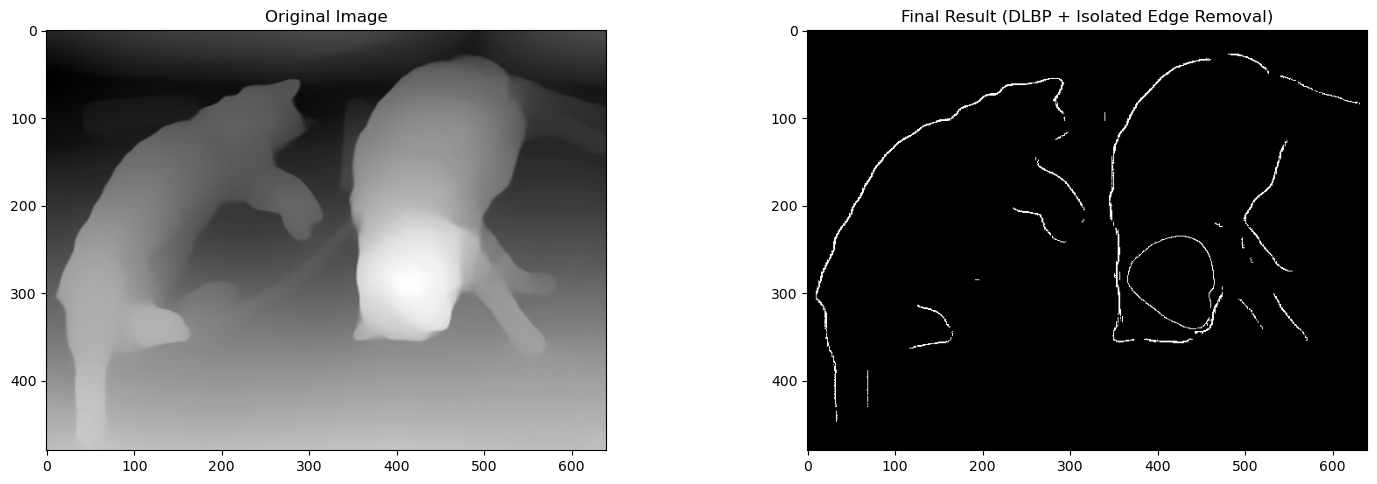

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_contrast_stretching(image):
    low_value = np.percentile(image, 1)
    high_value = np.percentile(image, 99)
    
    stretched_image = np.where(image < low_value, 0, image)
    stretched_image = np.where((low_value <= stretched_image) & (stretched_image <= high_value),
                               (255 / (high_value - low_value)) * (stretched_image - low_value), stretched_image)
    stretched_image = np.where(stretched_image > high_value, 255, stretched_image)

    return stretched_image


def calculate_DLBP(center_pixel, neighbors):
    i_max = np.max(neighbors)
    i_aver = np.mean(neighbors)
    i_T = i_max - i_aver
    LBP_value = sum(1 if neighbor - center_pixel >= i_T else 0 for neighbor in neighbors)
    DLBP_value = 1 if LBP_value >= 1 else 0
    return DLBP_value

def calculate_R(center_pixel, neighbors, threshold=1.5):
    i_aver = np.mean(neighbors)
    return calculate_DLBP(center_pixel, neighbors) if abs(center_pixel - i_aver) >= threshold else 0

def calculate_DLBP_image(image):
    neighborhood_size = 3
    output_image = np.zeros_like(image)

    for y in range(neighborhood_size, image.shape[0] - neighborhood_size):
        for x in range(neighborhood_size, image.shape[1] - neighborhood_size):
            center_pixel = image[y, x]
            neighbors = [image[y-1, x-1], image[y-1, x], image[y-1, x+1],
                         image[y, x-1], image[y, x+1],
                         image[y+1, x-1], image[y+1, x], image[y+1, x+1]]

            R_value = calculate_R(center_pixel, neighbors)
            output_image[y, x] = R_value

    return output_image

def remove_isolated_edges(depth_edge_map, mask_size=5):
    h, w = depth_edge_map.shape
    half_mask = mask_size // 2
    mask = np.ones((mask_size, mask_size), dtype=np.uint8)

    for y in range(half_mask, h - half_mask):
        for x in range(half_mask, w - half_mask):
            neighborhood = depth_edge_map[y - half_mask:y + half_mask + 1, x - half_mask:x + half_mask + 1]
            if (np.all(neighborhood[0, :] != 1) and np.all(neighborhood[-1, :] != 1) and
                np.all(neighborhood[:, 0] != 1) and np.all(neighborhood[:, -1] != 1)):
                depth_edge_map[y - half_mask:y + half_mask + 1, x - half_mask:x + half_mask + 1] = np.zeros_like(neighborhood)
            elif (np.all(neighborhood[1, :] != 1) and np.all(neighborhood[-2, :] != 1) and
                  np.all(neighborhood[:, 1] != 1) and np.all(neighborhood[:, -2] != 1)):
                depth_edge_map[y, x] = 0

    return np.uint8(depth_edge_map)

def process_depth_image(image_path):
    # Load the depth image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching
    stretched_image = apply_contrast_stretching(image)

    # Apply Gaussian blur

    # Calculate DLBP image
    dlbp_image = calculate_DLBP_image(stretched_image)

    # Remove isolated edges
    final_result = remove_isolated_edges(dlbp_image)

    # Display the original and processed images
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 2, 1), plt.imshow(image, cmap='gray'), plt.title('Original Image')
    plt.subplot(2, 2, 2), plt.imshow(final_result, cmap='gray'), plt.title('Final Result (DLBP + Isolated Edge Removal)')
    plt.show()

# Example usage
image_path = 'depth-estimation-output.png'
process_depth_image(image_path)


In [62]:
import cv2

# Load the image
image_path = 'depth_image.png'
original_image = cv2.imread(image_path)

# Get the original width and height
original_height, original_width, _ = original_image.shape

# Downsample by a factor of 5
downsample_factor = 5
new_width = original_width // downsample_factor
new_height = original_height // downsample_factor

# Use cv2.resize to downsample the image
downsampled_image = cv2.resize(original_image, (new_width, new_height))
# Save the downsized image
output_path = 'downsampled_image_1-5.jpg'
cv2.imwrite(output_path, downsampled_image)
# Display the original and downsized images (optional)
cv2.imshow('Original Image', original_image)
cv2.imshow('Downsampled Image', downsampled_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [66]:
import cv2
import numpy as np

def canny_edge_detection(image, low_threshold, high_threshold):
    # Step 1: Gaussian Smoothing
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Intensity Gradients
    gradient_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the magnitude and direction of the gradient
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    # Step 3: Non-maximum Suppression
    suppressed_magnitude = non_max_suppression(gradient_magnitude, gradient_direction)

    # Step 4: Double Thresholding
    edges = double_threshold(suppressed_magnitude, low_threshold, high_threshold)

    # Step 5: Edge Tracking by Hysteresis
    edges = edge_tracking(edges)

    return edges.astype(np.uint8) * 255

def non_max_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    suppressed_magnitude = np.zeros_like(magnitude)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = direction[i, j]

            # Compare with neighbors along the gradient direction
            q = magnitude[i, j]
            if ((-np.pi / 8 <= angle < np.pi / 8) or
                (7 * np.pi / 8 <= angle <= np.pi) or
                (-7 * np.pi / 8 <= angle < -np.pi / 8)):
                neighbors = [magnitude[i, j - 1], magnitude[i, j + 1]]
            elif ((np.pi / 8 <= angle < 3 * np.pi / 8) or
                  (-7 * np.pi / 8 <= angle < -5 * np.pi / 8)):
                neighbors = [magnitude[i - 1, j + 1], magnitude[i + 1, j - 1]]
            elif ((3 * np.pi / 8 <= angle < 5 * np.pi / 8) or
                  (-5 * np.pi / 8 <= angle < -3 * np.pi / 8)):
                neighbors = [magnitude[i - 1, j], magnitude[i + 1, j + 1]]
            else:  # (-3 * np.pi / 8 <= angle < -np.pi / 8) or (5 * np.pi / 8 <= angle < 7 * np.pi / 8)
                neighbors = [magnitude[i - 1, j - 1], magnitude[i + 1, j]]

            # Suppress non-maximum values
            if q >= max(neighbors):
                suppressed_magnitude[i, j] = q

    return suppressed_magnitude

def double_threshold(magnitude, low_threshold, high_threshold):
    # Create binary edge map based on double thresholding
    edges = np.zeros_like(magnitude)
    strong_edges = (magnitude >= high_threshold)
    weak_edges = (magnitude >= low_threshold) & (magnitude < high_threshold)

    edges[strong_edges] = 1
    edges[weak_edges] = 0.5  # Weak edges are marked with 0.5 for tracking

    return edges

def edge_tracking(edges):
    rows, cols = edges.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if edges[i, j] == 0.5:
                neighbors = edges[i-1:i+2, j-1:j+2]
                if np.max(neighbors) == 1:
                    edges[i, j] = 1

    return edges

# Read the input image
img = cv2.imread('depth-estimation-output.png', cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection manually
edges_manual = canny_edge_detection(img, low_threshold=50, high_threshold=150)

# Display the original and manually detected edges images
cv2.imshow('Original Image', img)
cv2.imshow('Canny Edges (Manual)', edges_manual)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(2, 2, 2), plt.imshow(edges_manual, cmap='gray'), plt.title('Final Result (DLBP + Isolated Edge Removal)')
plt.show()